# 230607_causal_tracing_weights_v3
전체 데이터셋 대상

# Import libraries

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from os import listdir
import json
import math
import seaborn as sns

/rds/general/user/jj1122/home/anaconda3/envs/m2d2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
sns.set_style("darkgrid")

In [3]:
# dataset_nm = "Health_and_fitness"
# dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"
cache_dir="/rds/general/user/jj1122/ephemeral/.cache/huggingface"
data_dir = "../m2d2/dataset"

In [4]:
def get_model_path(model_id):
    model_path_format = "/rds/general/user/jj1122/home/projects/m2d2/dataset/{model_id}/models"
    ckpt_path_format = "/checkpoint-{ckpt}"

    if model_id == "gpt2":
        model_path = "gpt2"
#         ckpt = "zs"
    else:
        model_path = model_path_format.format(model_id=model_id)
        l_dir = listdir(model_path)

        if all([len(x.split(".")) == 1 for x in l_dir]):
            ckpt = max([int(x.split("-")[1]) for x in l_dir])
            model_path += ckpt_path_format.format(ckpt=ckpt)
#         else:
#             ckpt = "final"
    return model_path

In [5]:
list_models = [
    "cs_l1",
    "nlin_l1",
    "Health_and_fitness",
    "Natural_and_physical_sciences",
    "Religion_and_belief_systems",
    "Culture_and_the_arts",
    "General_referece",
    "econ_l1",
    "History_and_events",
    "Human_activites",
    "Mathematics_and_logic",
#     "astro-ph_l1",
#     "cond-mat_l1",
    "eess_l1",
#     "math_l1",
#     "physics_l1 (ERROR)",
    "q-bio_l1",
    "q-fin_l1",
    "stat_l1",
    "Philosophy",
    "Philosophy_and_thinking",
    "Society_and_social_sciences",
    "Technology_and_applied_sciences",
]
len(list_models), len(set(list_models))

(19, 19)

In [6]:
device_id = 'cpu'
n_layers = 12
list_modules = ['attn', 'mlp']
trace_module_id = "transformer.h.{l}.{m}"

In [7]:
list_trace_module_ids = []

for l in range(n_layers):
    for m in list_modules:
        list_trace_module_ids.append(trace_module_id.format(l=l, m=m))

print(list_trace_module_ids[:3])

['transformer.h.0.attn', 'transformer.h.0.mlp', 'transformer.h.1.attn']


# Model

## load **17** finetuned models with EarlyStopper

In [8]:
config_models = {model_id: {} for model_id in list_models}
for model_id in list_models:
    config_models[model_id]["model_path"] = get_model_path(model_id)
    json_path = config_models[model_id]["model_path"] + "/trainer_state.json"
    with open(json_path, "r") as json_file:
        trainer_state = json.load(json_file)
        config_models[model_id]["ppl"] = math.exp(trainer_state["best_metric"])
        config_models[model_id]["steps"] = int(trainer_state["best_model_checkpoint"].split("/")[-1].split("-")[-1])
        config_models[model_id]["eps"] = float(trainer_state["epoch"])

In [9]:
for ds, conf in config_models.items():
    print("{ds}: {ppl}".format(ds=ds, ppl=conf['ppl']))

cs_l1: 9.60544432812854
nlin_l1: 14.119560045136609
Health_and_fitness: 18.23982025306327
Natural_and_physical_sciences: 19.102488435453818
Religion_and_belief_systems: 20.79687871495301
Culture_and_the_arts: 18.6478693827917
General_referece: 22.272872862552227
econ_l1: 16.350728007270085
History_and_events: 21.398143926660882
Human_activites: 21.086355751417145
Mathematics_and_logic: 17.909318075703332
eess_l1: 16.222066145726654
q-bio_l1: 13.265775329547123
q-fin_l1: 21.04296390462747
stat_l1: 12.691931933643405
Philosophy: 24.199961950482898
Philosophy_and_thinking: 22.33016986869287
Society_and_social_sciences: 20.508451481130514
Technology_and_applied_sciences: 21.131902651488446


In [9]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", cache_dir=cache_dir)

## Get difference in weights
```diff = np.mean(np.abs(model_a.weights - model_b.weights))```

In [11]:
# for k, v in base_model.named_parameters():
#     print(k)
# #     if k  == "transformer.h.0.attn.c_attn.bias":
# #         attn_b = v
# #     if k  == "transformer.h.0.attn.c_attn.weight":
# #         attn_w = v
# #     if "ln_1" in k and "weight" in k :
# # #         print(k)
# #         ln_1_w = v

# #     if "ln_1" in k and "bias" in k :
# # #         print(k)
# #         ln_1_b = v

# #     if "head" in k :
# # #         print(k)
# #         head = v


In [12]:
tuned_model = GPT2LMHeadModel.from_pretrained(config_models["cs_l1"]["model_path"]).to(device_id)

In [13]:
# for x in tuned_model.lm_head.named_parameters():
#     print(x)

In [14]:
def get_diff_from_tensors(a, b):
    return torch.abs(a - b).mean().item()

dict_diff_weights = {}
dict_module_params = {}
for k, v_dict in config_models.items():
#     print(k)
#     dict_diff_weights[k +"."+tuned_tup[0]]
    tuned_model = GPT2LMHeadModel.from_pretrained(v_dict["model_path"]).to(device_id)
    for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):

        dict_module_params[base_tup[0]]= base_tup[1].numel()
        
        if "c_attn" in tuned_tup[0]:
            dim_size = len(base_tup[1].shape) - 1
            emb_size = base_tup[1].shape[dim_size] // 3
            
            base_q, base_k, base_v = torch.split(base_tup[1], [emb_size]*3, dim=dim_size)
            tuned_q, tuned_k, tuned_v = torch.split(tuned_tup[1], [emb_size]*3, dim=dim_size)

            assert base_q.shape == tuned_q.shape
            assert base_k.shape == tuned_k.shape
            assert base_v.shape == tuned_v.shape
            
            dict_diff_weights[k +"."+ tuned_tup[0].replace("c_attn", "c_attn_Q")] = get_diff_from_tensors(tuned_q, base_q)
            dict_diff_weights[k +"."+ tuned_tup[0].replace("c_attn", "c_attn_K")] = get_diff_from_tensors(tuned_k, base_k)
            dict_diff_weights[k +"."+ tuned_tup[0].replace("c_attn", "c_attn_V")] = get_diff_from_tensors(tuned_v, base_v)
        else:
            dict_diff_weights[k +"."+tuned_tup[0]] = get_diff_from_tensors(tuned_tup[1], base_tup[1])

#     for tuned_tup, base_tup in zip(list(tuned_model.lm_head.named_parameters()), list(base_model.lm_head.named_parameters())):
#         dict_module_params["transformer.ln_head.weight"]= base_tup[1].numel()
#         dict_diff_weights[k +"."+"transformer.ln_head.weight"] = get_diff_from_tensors(tuned_tup[1], base_tup[1])        
        
    del tuned_model

In [15]:
df_avg_diff_weights = pd.DataFrame.from_dict(dict_diff_weights, orient='index')

df_avg_diff_weights = df_avg_diff_weights.reset_index()
df_avg_diff_weights.columns = ["code", "diff"]

df_avg_diff_weights["code_split"] = df_avg_diff_weights["code"].str.split(".")
df_avg_diff_weights["dataset"] = df_avg_diff_weights["code_split"].apply(lambda l: l[0])

df_avg_diff_weights["layer"] = df_avg_diff_weights["code_split"].apply(lambda l: int(l[3]) if l[2] == "h" else -1)


df_avg_diff_weights["module"] = df_avg_diff_weights["code_split"].apply(lambda l: l[4] if l[2] == "h" else l[2])
df_avg_diff_weights["sub_module"] = df_avg_diff_weights["module"]
df_avg_diff_weights.loc[df_avg_diff_weights["module"].isin(["attn", "mlp"]), "sub_module"] \
    += df_avg_diff_weights["code_split"].loc[df_avg_diff_weights["module"].isin(["attn", "mlp"])].apply(lambda l: l[5])

df_avg_diff_weights.loc[df_avg_diff_weights["sub_module"] == "ln_f", "layer"] = 99

# df_avg_diff_weights['final_module'] = \
#     df_avg_diff_weights[["layer", "module", "sub_module"]]\
#         .apply(lambda row: "-".join([str(row["layer"]), row["module"], row["sub_module"]]), axis=1)

df_avg_diff_weights["w_or_b"] = df_avg_diff_weights["code_split"].apply(lambda l: l[-1])

for dataset, d in config_models.items():
    for k, v in d.items():
        if k != "model_path":
            df_avg_diff_weights.loc[df_avg_diff_weights.dataset == dataset, k] = v

del df_avg_diff_weights["code"], df_avg_diff_weights["code_split"]

only_transformer_layers = ~(df_avg_diff_weights.layer.isin([-1, 99]))


### boxplot for the mean weight- and bias-differences by layers
##### Due to the different distributions, There exist too many **outliers**
##### Original weight-differences could cause confusion that the differences from fine-tuning or just running time

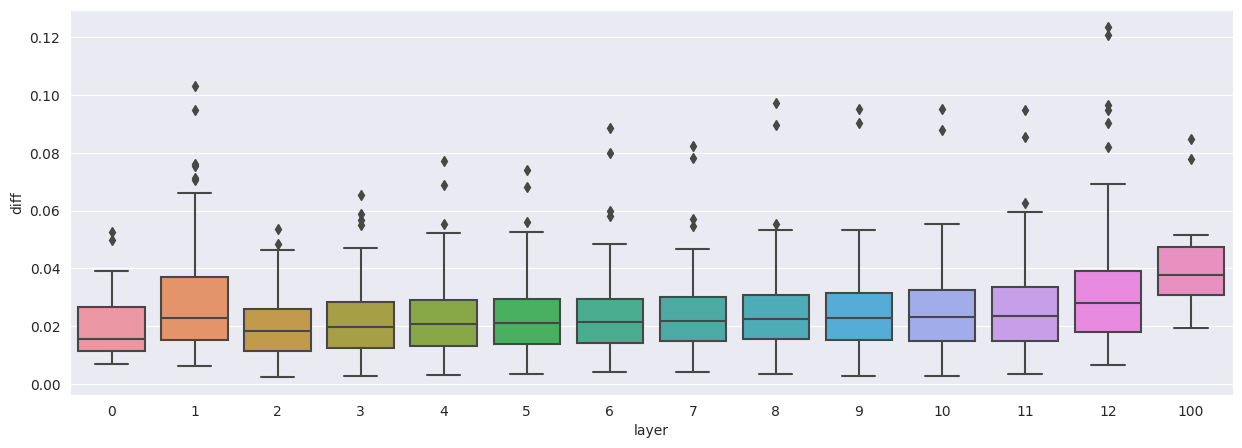

In [16]:
plt.rcParams["figure.figsize"] = (15,5)
df_avg_diff_weights.layer += 1
sns.boxplot(
    df_avg_diff_weights.loc[df_avg_diff_weights.w_or_b == 'weight'],
    x='layer',  y='diff'#, hue='w_or_b'
#     , errorbar='se'
)
df_avg_diff_weights.layer -= 1

In [17]:
# df_temp_agg = df_avg_diff_weights.groupby(["layer", "w_or_b"])[['diff']]\
#     .agg({"diff": ["mean", "median"]})

# df_temp_agg = df_temp_agg.reset_index()
# df_temp_agg = df_temp_agg.melt(value_vars=["mean", "median"], ignore_index=False)
# plt.rcParams["figure.figsize"] = (5,5)
# g = sns.relplot(df_temp_agg.loc[df_temp_agg.w_or_b == 'weight'], x='mean', y='median', col='w_or_b')
# g.set(ylim=(0, 0.035), xlim=(0, 0.035))
# # , sizes=(0.35, 0.35)

### Corrleation between the difference in weights and training time from different datasets


In [18]:
# df_avg_diff_weights['diff'].mean()

In [19]:
# df_avg_diff_weights

In [20]:
# df_avg_diff_weights.groupby(['dataset', 'eps', 'steps'])[['diff']].mean().reset_index().corr()

### Scaling the difference of weights
For each dataset, ```new_diff = original_diff  / n_steps  * 10**6```

In [21]:
df_avg_diff_weights['diff_v2'] = df_avg_diff_weights['diff'] / df_avg_diff_weights['steps'] * 10**6

In [22]:
df_avg_diff_weights

,diff,dataset,layer,module,sub_module,w_or_b,ppl,steps,eps,diff_v2
0,0.052673,cs_l1,-1,wte,wte,weight,9.605444,120000.0,3.034820,0.438945
1,0.017641,cs_l1,-1,wpe,wpe,weight,9.605444,120000.0,3.034820,0.147004
2,0.103037,cs_l1,0,ln_1,ln_1,weight,9.605444,120000.0,3.034820,0.858642
3,0.009159,cs_l1,0,ln_1,ln_1,bias,9.605444,120000.0,3.034820,0.076326
4,0.076053,cs_l1,0,attn,attnc_attn_Q,weight,9.605444,120000.0,3.034820,0.633771
...,...,...,...,...,...,...,...,...,...,...
3719,0.006527,Technology_and_applied_sciences,11,mlp,mlpc_fc,bias,21.131903,60000.0,10.188989,0.108790
3720,0.039139,Technology_and_applied_sciences,11,mlp,mlpc_proj,weight,21.131903,60000.0,10.188989,0.652315
3721,0.008047,Technology_and_applied_sciences,11,mlp,mlpc_proj,bias,21.131903,60000.0,10.188989,0.134117
3722,0.037557,Technology_and_applied_sciences,99,ln_f,ln_f,weight,21.131903,60000.0,10.188989,0.625943


### boxplot for the scaled and mean weight- and bias-differences by layers


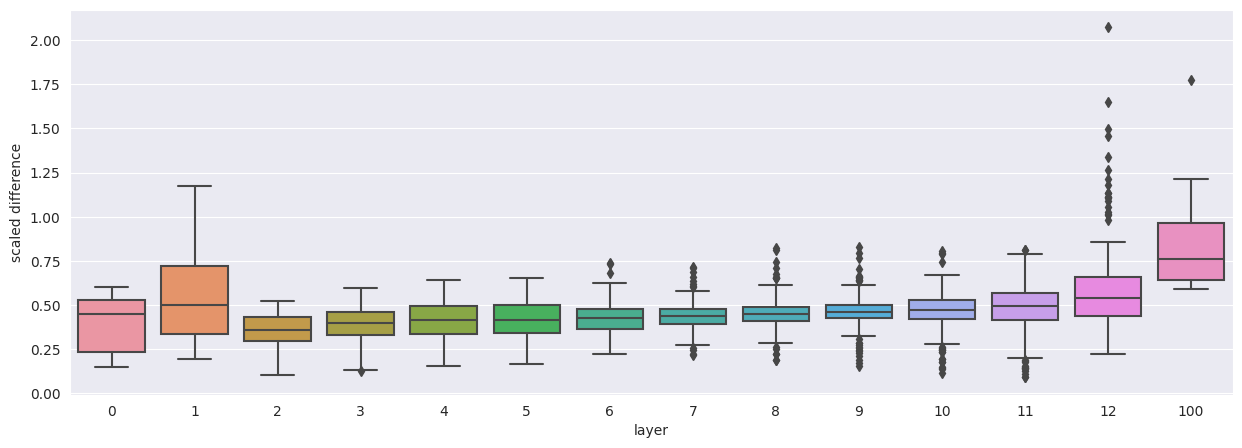

In [23]:
plt.rcParams["figure.figsize"] = (15,5)
df_avg_diff_weights.layer += 1
df_avg_diff_weights = df_avg_diff_weights.rename({"diff_v2": "scaled difference"}, axis=1)
sns.boxplot(
#     df_avg_diff_weights,
    df_avg_diff_weights.loc[df_avg_diff_weights.w_or_b == 'weight'],
    x='layer',  y='scaled difference'#, hue='w_or_b'
#     , errorbar='se'
)
df_avg_diff_weights.layer -= 1
df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)

### the number of parameters for each sub_module

In [41]:
df_module_params.loc[
    (df_module_params.code.str.contains("attn")) 
    & (df_module_params.code.str.contains("3"))
    & (df_module_params.w_or_b == "weight")

]

,code,n_params,code_split,layer,module,sub_module,w_or_b
40,transformer.h.3.attn.c_attn.weight,1769472,"[transformer, h, 3, attn, c_attn, weight]",3,attn,attnc_attn,weight
42,transformer.h.3.attn.c_proj.weight,589824,"[transformer, h, 3, attn, c_proj, weight]",3,attn,attnc_proj,weight


In [45]:
df_module_params.loc[
    (df_module_params.code.str.contains("mlp")) 
    & (df_module_params.code.str.contains("3"))
    & (df_module_params.w_or_b == "weight")

]

,code,n_params,code_split,layer,module,sub_module,w_or_b
46,transformer.h.3.mlp.c_fc.weight,2359296,"[transformer, h, 3, mlp, c_fc, weight]",3,mlp,mlpc_fc,weight
48,transformer.h.3.mlp.c_proj.weight,2359296,"[transformer, h, 3, mlp, c_proj, weight]",3,mlp,mlpc_proj,weight


In [47]:
base_model.transformer.h[3].mlp.c_fc.weight.shape

torch.Size([768, 3072])

In [44]:
base_model.transformer.h[3].attn.c_proj.weight.shape

torch.Size([768, 768])

In [24]:
df_module_params = pd.DataFrame.from_dict(dict_module_params, orient='index')
df_module_params = df_module_params.reset_index()
df_module_params.columns = ["code", "n_params"]


In [25]:
df_module_params["code_split"] = df_module_params["code"].str.split(".")
df_module_params["layer"] = df_module_params["code_split"].apply(lambda l: int(l[2]) if l[1] == "h" else -1)
df_module_params["module"] = df_module_params["code_split"].apply(lambda l: l[3] if l[1] == "h" else l[1])
df_module_params["sub_module"] = df_module_params["module"]
df_module_params.loc[df_module_params["module"].isin(["attn", "mlp"]), "sub_module"] \
    += df_module_params["code_split"].loc[df_module_params["module"].isin(["attn", "mlp"])].apply(lambda l: l[4])
df_module_params.loc[df_module_params["sub_module"] == "ln_f", "layer"] = 99
df_module_params["w_or_b"] = df_module_params["code_split"].apply(lambda l: l[-1])


In [26]:
df_module_params

,code,n_params,code_split,layer,module,sub_module,w_or_b
0,transformer.wte.weight,38597376,"[transformer, wte, weight]",-1,wte,wte,weight
1,transformer.wpe.weight,786432,"[transformer, wpe, weight]",-1,wpe,wpe,weight
2,transformer.h.0.ln_1.weight,768,"[transformer, h, 0, ln_1, weight]",0,ln_1,ln_1,weight
3,transformer.h.0.ln_1.bias,768,"[transformer, h, 0, ln_1, bias]",0,ln_1,ln_1,bias
4,transformer.h.0.attn.c_attn.weight,1769472,"[transformer, h, 0, attn, c_attn, weight]",0,attn,attnc_attn,weight
...,...,...,...,...,...,...,...
143,transformer.h.11.mlp.c_fc.bias,3072,"[transformer, h, 11, mlp, c_fc, bias]",11,mlp,mlpc_fc,bias
144,transformer.h.11.mlp.c_proj.weight,2359296,"[transformer, h, 11, mlp, c_proj, weight]",11,mlp,mlpc_proj,weight
145,transformer.h.11.mlp.c_proj.bias,768,"[transformer, h, 11, mlp, c_proj, bias]",11,mlp,mlpc_proj,bias
146,transformer.ln_f.weight,768,"[transformer, ln_f, weight]",99,ln_f,ln_f,weight


# Result

### Avg diff group by layer and moudle

In [27]:
# df_avg_diff_weights.loc[only_transformer_layers]\
#     .groupby(["layer", "module"])[['diff_v2']].describe()[[('diff_v2', 'mean'), ('diff_v2', 'std')]]\
#     .sort_values(by=[('diff_v2', 'mean'), ('diff_v2', 'std')]).unstack(-2)

In [28]:
# df_avg_diff_weights.loc[~only_transformer_layers]\
#     .groupby(["module"])[['diff_v2']].describe()[[('diff_v2', 'mean'), ('diff_v2', 'std')]]\
#     .sort_values(by=[('diff_v2', 'mean'), ('diff_v2', 'std')])

In [29]:
# df_avg_diff_weights.loc[df_avg_diff_weights.layer == 99, 'module'] == 'ln_1'

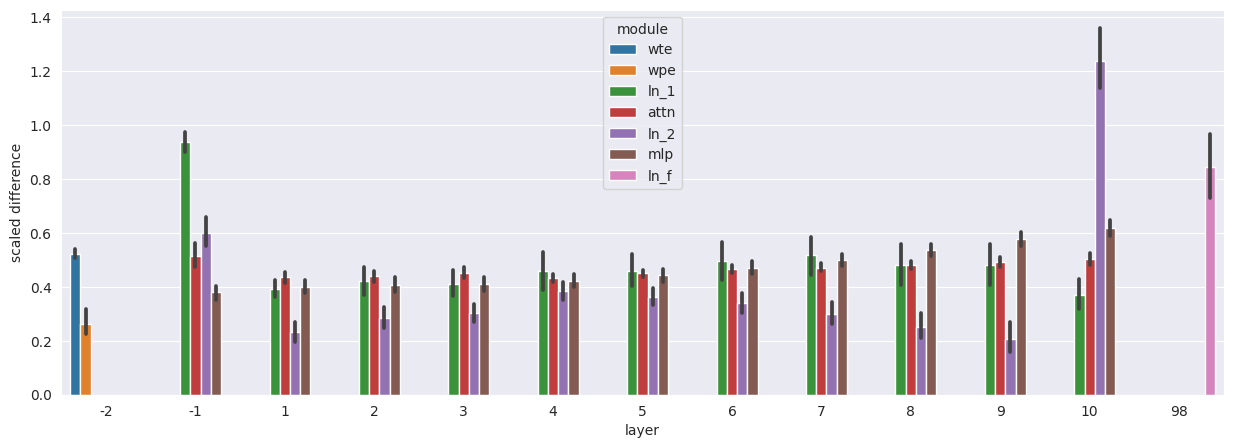

In [39]:
plt.rcParams["figure.figsize"] = (15,5)
df_avg_diff_weights.loc[df_avg_diff_weights.layer == 99, 'module'] = 'ln_2'
df_avg_diff_weights.layer += 1
df_avg_diff_weights = df_avg_diff_weights.rename({"diff_v2": "scaled difference"}, axis=1)
sns.barplot(
    df_avg_diff_weights.loc[
        (df_avg_diff_weights.w_or_b == 'weight')
#         & ~(df_avg_diff_weights.layer.isin([ -1, 99]))  
        & ~(df_avg_diff_weights.layer.isin([0]))  
#         & (df_avg_diff_weights.dataset == 'cs_l1')
    ], 
    x='layer', hue='module', y='scaled difference'
#     , errorbar='se'
)
df_avg_diff_weights.layer -= 1

df_avg_diff_weights.loc[df_avg_diff_weights.layer == 99, 'module'] = 'ln_f'
df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)

<Axes: xlabel='layer', ylabel='diff_v2'>

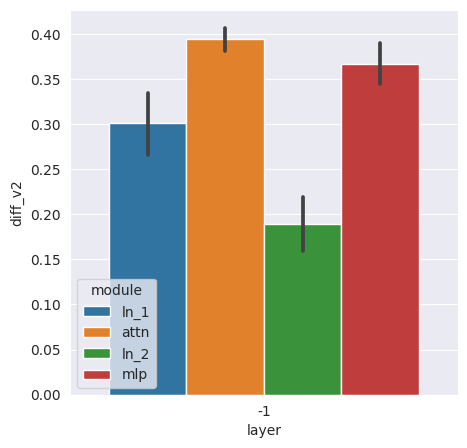

In [40]:
plt.rcParams["figure.figsize"] = (5,5)

sns.barplot(
    df_avg_diff_weights.loc[
        (df_avg_diff_weights.layer.isin([ -1, 99])) 
        & (df_avg_diff_weights.w_or_b == 'weight')
#         & (df_avg_diff_weights.dataset == 'cs_l1')
    ], 
    x='layer', hue='module', y='diff_v2', estimator="mean"
#     , errorbar='se'
)

### Avg diff group by layer and sub_module

/var/tmp/pbs.7711131.pbs/ipykernel_3900567/1073579367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['layer'] += 1


<Axes: xlabel='layer', ylabel='scaled difference'>

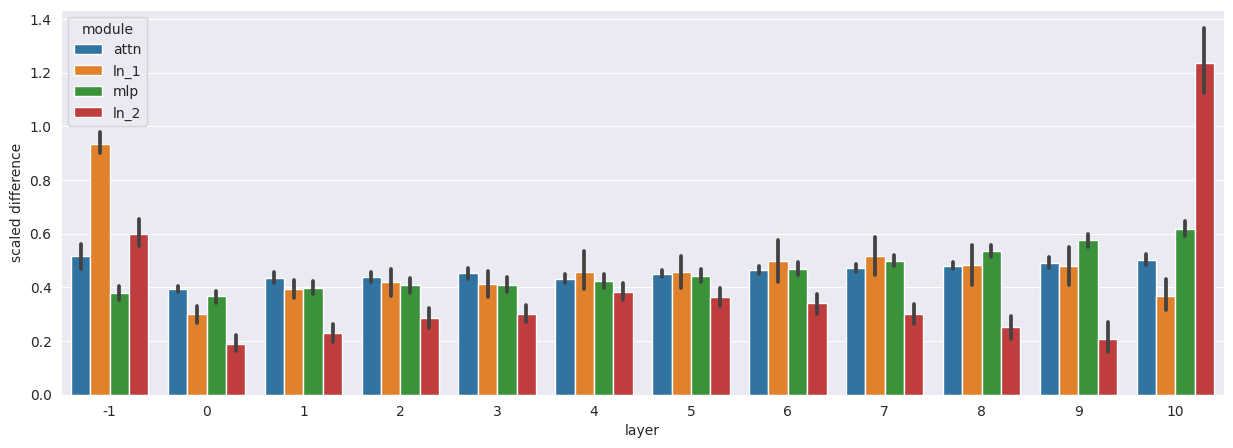

In [41]:

plt.rcParams["figure.figsize"] = (15,5)


df_temp = df_avg_diff_weights.loc[
        only_transformer_layers
        & (df_avg_diff_weights.w_or_b == 'weight')
    ]
# df_temp['sub_module'] = df_temp['sub_module']\
#     .apply(lambda x: x.split("_")[-1] if x.startswith('attnc') or x.startswith('mlpc') else x)
df_temp['layer'] += 1
df_temp = df_temp.rename({"diff_v2": "scaled difference"}, axis=1)

sns.barplot(
    df_temp, 
    x='layer', hue='module', y='scaled difference',
    hue_order=['attn', 'ln_1', 'mlp', 'ln_2']

)

In [35]:
df_avg_diff_weights.loc[df_avg_diff_weights.module == 'attn', ['module', 'sub_module']].drop_duplicates()

,module,sub_module
4,attn,attnc_attn_Q
5,attn,attnc_attn_K
6,attn,attnc_attn_V
10,attn,attnc_proj


/var/tmp/pbs.7714162.pbs/ipykernel_4059100/1586893371.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['sub_module'] = df_temp['sub_module']\


<Axes: xlabel='sub_module', ylabel='scaled difference'>

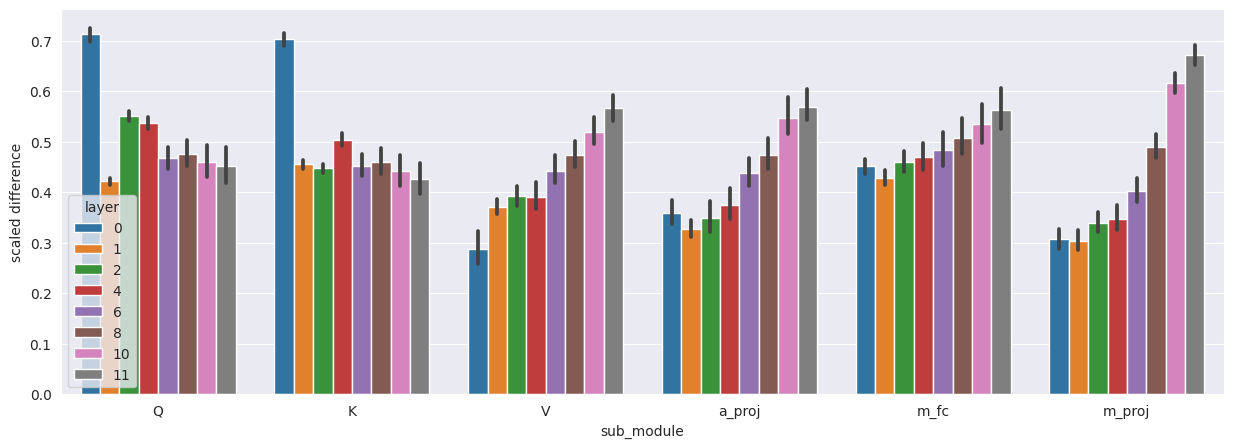

In [64]:
plt.rcParams["figure.figsize"] = (15,5)


df_temp = df_avg_diff_weights.loc[
#         only_transformer_layers
        df_avg_diff_weights.layer.isin([0,  1, 2, 4, 6, 8, 10, 11])\
#         & df_avg_diff_weights.module.isin(['attn', 'mlp'])
        & (df_avg_diff_weights.w_or_b == 'weight')
    ]
df_temp['sub_module'] = df_temp['sub_module']\
    .apply(lambda x: x.split("_")[-1] if x.startswith('attnc') or x.startswith('mlpc') else x)
df_temp.loc[(df_temp.module == 'attn') & (df_temp.sub_module == 'proj'), 'sub_module'] = 'a_' + df_temp.loc[(df_temp.module == 'attn') & (df_temp.sub_module == 'proj'), 'sub_module']
df_temp.loc[(df_temp.module == 'mlp') & (df_temp.sub_module == 'proj'), 'sub_module'] = 'm_' + df_temp.loc[(df_temp.module == 'mlp') & (df_temp.sub_module == 'proj'), 'sub_module']
df_temp.loc[(df_temp.module == 'mlp') & (df_temp.sub_module == 'fc'), 'sub_module'] = 'm_' + df_temp.loc[(df_temp.module == 'mlp') & (df_temp.sub_module == 'fc'), 'sub_module']

# df_temp['layer'] += 1

df_temp = df_temp.rename({"diff_v2": "scaled difference"}, axis=1)


sns.barplot(
    df_temp, 
    x='sub_module', hue='layer', y='scaled difference',
#     order=['ln_1', 'Q', 'K', 'V', 'a_proj', 'ln_2', 'm_fc', 'm_proj' ]
    order=['Q', 'K', 'V', 'a_proj', 'm_fc', 'm_proj' ]
    
)

In [55]:
df_temp.groupby('sub_module')['']

,diff,dataset,layer,module,sub_module,w_or_b,ppl,steps,eps,scaled difference
2,0.103037,cs_l1,0,ln_1,ln_1,weight,9.605444,120000.0,3.034820,0.858642
4,0.076053,cs_l1,0,attn,Q,weight,9.605444,120000.0,3.034820,0.633771
5,0.075347,cs_l1,0,attn,K,weight,9.605444,120000.0,3.034820,0.627889
6,0.023556,cs_l1,0,attn,V,weight,9.605444,120000.0,3.034820,0.196303
10,0.033362,cs_l1,0,attn,a_proj,weight,9.605444,120000.0,3.034820,0.278016
...,...,...,...,...,...,...,...,...,...,...
3710,0.032400,Technology_and_applied_sciences,11,attn,V,weight,21.131903,60000.0,10.188989,0.540005
3714,0.031698,Technology_and_applied_sciences,11,attn,a_proj,weight,21.131903,60000.0,10.188989,0.528303
3716,0.063425,Technology_and_applied_sciences,11,ln_2,ln_2,weight,21.131903,60000.0,10.188989,1.057087
3718,0.029932,Technology_and_applied_sciences,11,mlp,m_fc,weight,21.131903,60000.0,10.188989,0.498874


In [63]:
# df_temp_temp = df_temp.groupby(['layer', 'sub_module'])[["scaled difference"]].mean().reset_index()
# df_temp_temp.groupby(["sub_module"])[["scaled difference"]].skew()

,scaled difference
sub_module,
K,2.507115
Q,1.752979
V,0.005813
a_proj,0.544687
ln_1,2.162814
ln_2,2.175672
m_fc,0.562323
m_proj,0.889685


### Top 10 of avg diff group by layer and (module or sub_module)

In [43]:
df_avg_diff_weights[['sub_module']].drop_duplicates()

,sub_module
0,wte
1,wpe
2,ln_1
4,attnc_attn_Q
5,attnc_attn_K
6,attnc_attn_V
10,attnc_proj
12,ln_2
14,mlpc_fc
16,mlpc_proj


In [44]:
base_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [45]:
for k, v in base_model.transformer.h[0].attn.named_parameters():
    print(k)

c_attn.weight
c_attn.bias
c_proj.weight
c_proj.bias


In [46]:
df_avg_diff_weights.sub_module.unique()

array(['wte', 'wpe', 'ln_1', 'attnc_attn_Q', 'attnc_attn_K',
       'attnc_attn_V', 'attnc_proj', 'ln_2', 'mlpc_fc', 'mlpc_proj',
       'ln_f'], dtype=object)

In [54]:
df_avg_diff_weights.head(10)

,diff,dataset,layer,module,sub_module,w_or_b,ppl,steps,eps,diff_v2
0,0.052673,cs_l1,0,wte,wte,weight,9.605444,120000.0,3.03482,0.438945
1,0.017641,cs_l1,0,wpe,wpe,weight,9.605444,120000.0,3.03482,0.147004
2,0.103037,cs_l1,1,ln_1,ln_1,weight,9.605444,120000.0,3.03482,0.858642
3,0.009159,cs_l1,1,ln_1,ln_1,bias,9.605444,120000.0,3.03482,0.076326
4,0.076053,cs_l1,1,attn,attnc_attn_Q,weight,9.605444,120000.0,3.03482,0.633771
5,0.075347,cs_l1,1,attn,attnc_attn_K,weight,9.605444,120000.0,3.03482,0.627889
6,0.023556,cs_l1,1,attn,attnc_attn_V,weight,9.605444,120000.0,3.03482,0.196303
7,0.053737,cs_l1,1,attn,attnc_attn_Q,bias,9.605444,120000.0,3.03482,0.447812
8,0.000057,cs_l1,1,attn,attnc_attn_K,bias,9.605444,120000.0,3.03482,0.000479
9,0.008515,cs_l1,1,attn,attnc_attn_V,bias,9.605444,120000.0,3.03482,0.070957


In [66]:
df_temp_m = df_avg_diff_weights.loc[df_avg_diff_weights.w_or_b == "weight"]\
    .groupby(["module", "layer"])[["diff_v2"]].mean()\
    .sort_values("diff_v2", ascending=False).head(15).reset_index()\
    [['layer', 'module', 'diff_v2']]
# df_temp_m['layer'] += 1
df_temp_m = df_temp_m.rename({"layer": "m_layer", "diff_v2": "scaled difference"}, axis=1)
df_temp_m

,m_layer,module,scaled difference
0,11,ln_2,1.234640
1,0,ln_1,0.934858
2,99,ln_f,0.841996
3,11,mlp,0.617384
4,0,ln_2,0.599032
5,10,mlp,0.575131
6,9,mlp,0.535468
7,-1,wte,0.521521
8,8,ln_1,0.516149
9,0,attn,0.515497


In [48]:
df_temp_s = df_avg_diff_weights\
    .loc[
        (df_avg_diff_weights.w_or_b == "weight")
        &   (df_avg_diff_weights.module.isin(["mlp", "attn"]))
    ]\
    .groupby(["sub_module", "module", "layer"])[["diff_v2"]].mean()\
    .sort_values("diff_v2", ascending=False).head(20).reset_index()\
    [['layer', "module", 'sub_module', 'diff_v2']]
df_temp_s['layer'] += 1
df_temp_s['sub_module'] = df_temp_s['sub_module']\
    .apply(lambda x: x.split("_")[-1] if x.startswith('attnc') or x.startswith('mlpc') else x)
df_temp_s = df_temp_s.rename({"layer": "s_layer", "diff_v2": "scaled difference"}, axis=1)
df_temp_s

,s_layer,module,sub_module,scaled difference
0,-1,attn,Q,0.712102
1,-1,attn,K,0.703539
2,10,mlp,proj,0.672037
3,9,mlp,proj,0.615062
4,10,attn,proj,0.569468
5,10,attn,V,0.565944
6,10,mlp,fc,0.562732
7,1,attn,Q,0.550584
8,8,mlp,proj,0.548930
9,9,attn,proj,0.546925


In [74]:
df_temp_m

188      0
2540     0
2        1
114      2
2932     0
        ..
1316    95
1332    96
812     98
1220    97
1204    98
Length: 1881, dtype: int64

In [87]:
df_temp_m = df_avg_diff_weights.loc[df_avg_diff_weights.w_or_b == "weight"]\
    .sort_values("diff", ascending=False)
df_temp_m['ranking'] = df_temp_m.groupby(["dataset"]).cumcount()
df_temp_m = df_temp_m.groupby(["layer", "module"])[['ranking']].mean().reset_index()
df_temp_m.sort_values("ranking",  ascending=True).head(15).reset_index(drop=True)

,layer,module,ranking
0,11,ln_2,0.000000
1,0,ln_1,1.210526
2,99,ln_f,3.736842
3,11,mlp,10.552632
4,0,ln_2,11.315789
5,10,mlp,14.184211
6,9,mlp,19.210526
7,-1,wte,22.947368
8,8,mlp,28.105263
9,11,attn,34.565789


In [88]:
df_temp_s = df_avg_diff_weights.loc[df_avg_diff_weights.w_or_b == "weight"]\
    .sort_values("diff", ascending=False)
df_temp_s['ranking'] = df_temp_s.groupby(["dataset"]).cumcount()
df_temp_s = df_temp_s.groupby(["layer", "sub_module"])[['ranking']].mean().reset_index()
df_temp_s.sort_values("ranking",  ascending=True).head(15).reset_index(drop=True)

,layer,sub_module,ranking
0,11,ln_2,0.000000
1,0,ln_1,1.210526
2,99,ln_f,3.736842
3,0,attnc_attn_Q,4.684211
4,0,attnc_attn_K,5.631579
5,11,mlpc_proj,6.052632
6,10,mlpc_proj,8.526316
7,0,ln_2,11.315789
8,11,attnc_proj,11.894737
9,11,attnc_attn_V,12.210526
